### Project Description from [**DataCamp**](https://www.datacamp.com/projects/184)

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds**.

<center><iframe width="560" height="315" src="https://www.youtube.com/embed/0G-612U2vQY" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></iframe></center>


### Data Description

<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

<a id='libraries'></a>
<h1 style="color:DarkSlateBlue" >1. Packages</h1>

In [397]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

<a id='load'></a>
<h1 style="color:DarkSlateBlue" >2. Loading data</h1>

In [398]:
path = "cookie_cats.csv"

df = pd.read_csv(path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


<a id='summary'></a>
<h1 style="color:DarkSlateBlue" >3. Data summary</h1>

In [399]:
# Summary stats by A/B groups
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


Text(0.5, 1.0, 'Before Removing The Extreme Value')

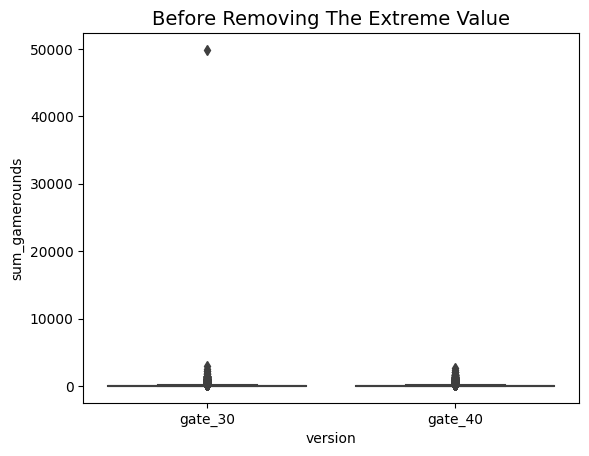

In [400]:
# Box plot for checking for outliers
sns.boxplot(x = df.version, y = df.sum_gamerounds)
plt.title("Before Removing The Extreme Value", fontsize = 14)

Text(0.5, 0.98, 'Before Removing The Extreme Value')

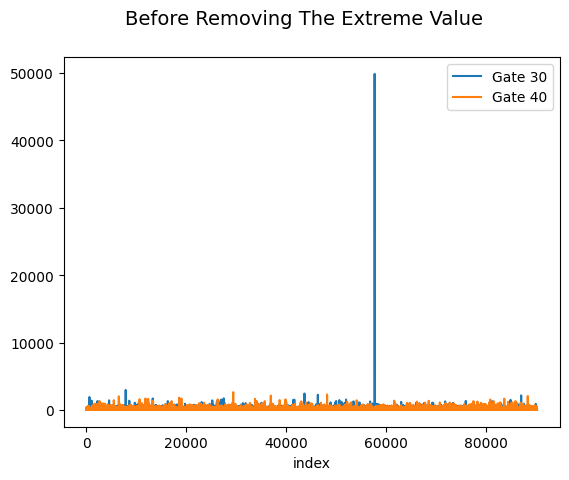

In [401]:
# Histogram plot for checking for outliers
df[df.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30")
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 14)

<a id='outliers'></a>
<h1 style="color:DarkSlateBlue" >4. Removing outlier</h1>

In [402]:
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


Text(0.5, 0.98, 'After Removing The Extreme Value')

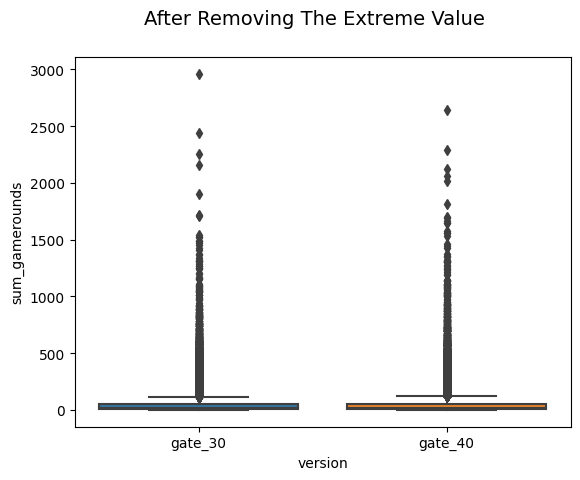

In [403]:
# Box plot after removing the outlier
sns.boxplot(x = df.version, y = df.sum_gamerounds)
plt.suptitle("After Removing The Extreme Value", fontsize = 14)

Text(0.5, 0.98, 'After Removing The Extreme Value')

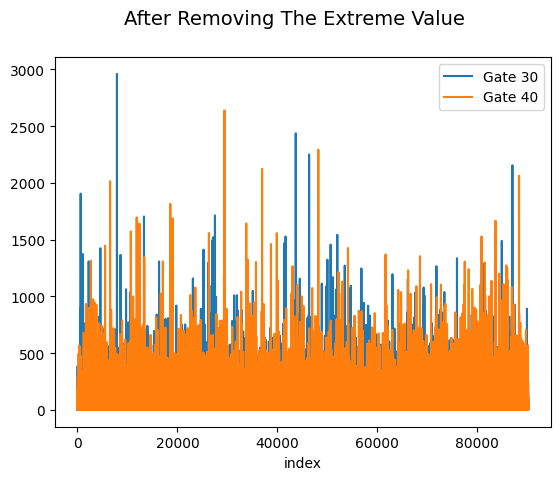

In [404]:
# Histogram plot after removing the outlier
df[(df.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30")
df[df.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("After Removing The Extreme Value", fontsize = 14)

<a id='details'></a>
<h1 style="color:DarkSlateBlue" >5. Some Exploratory Data Analysis</h1>

In [405]:
df.groupby("sum_gamerounds").userid.count().head(20)

sum_gamerounds
0     3994
1     5538
2     4606
3     3958
4     3629
5     2992
6     2861
7     2379
8     2267
9     2013
10    1752
11    1654
12    1570
13    1594
14    1519
15    1446
16    1342
17    1269
18    1228
19    1158
Name: userid, dtype: int64

- As can be seen from above, 3994 users never played the game! Maybe it's because they have no free time to play game, they prefer other games or they don't like the app.
- The number of users decreases as the levels progress. At the earliest levels, the churn rate is the highest. Additional research should be done to understand the reasons for the churn.

In [406]:
# How many users reached gate 30 & gate 40 levels?
df.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [407]:
# Summary stats by A/B groups
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


Looking at the summary statistics, the control and test groups look similar, but this should be investigated further by measuring the statistical significance of the differences.

**Retention variables meaning:**

<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>



In [408]:
# Calculating the % retention
pd.DataFrame({"RET1_COUNT": df["retention_1"].value_counts(),
              "RET7_COUNT": df["retention_7"].value_counts(),
              "RET1_RATIO": df["retention_1"].value_counts() / len(df),
              "RET7_RATIO": df["retention_7"].value_counts() / len(df)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


As seen from above:
- 55 percent of the players didn't play the game 1 day after insalling
- 81 percent of the players didn't play the game 7 day after insalling

In [409]:
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [410]:
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.

<a id='ab'></a>
<h1 style="color:DarkSlateBlue" >6. A/B Testing</h1>

###Steps:
- Two target variables to be checked: 1-day retention and 7-day retention
- Split by A/B groups
- Perform Proportions Z-test since target variables are binary

Performing the A/B test with 7-day retention as target variable.

In [411]:
# Define A/B groups
df["version"] = np.where(df.version == "gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [412]:
# Split into A/B groups for 1-day retention
groupA = df[df['version'] == "A"]['retention_1']
groupB = df[df['version'] == "B"]['retention_1']

In [413]:
successes = [groupA.sum(), groupB.sum()]
counts = [groupA.count(), groupB.count()]

p_val = proportions_ztest(successes, nobs = counts)[1]
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=counts, alpha=0.05)

print(f'P-Value - {p_val:.4f}')
print(f'CI 95% for control group - [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group - [{lower_treat:.3f}, {upper_treat:.3f}]')

P-Value - 0.0739
CI 95% for control group - [0.444, 0.453]
CI 95% for treatment group - [0.438, 0.447]


In [414]:
results_df = pd.DataFrame(columns=['p-value'])
results_df.loc['1-day retention'] = [p_val]
results_df

,p-value
1-day retention,0.073921


In [415]:
# Split into A/B groups for 7-day retention
groupA = df[df['version'] == "A"]['retention_7']
groupB = df[df['version'] == "B"]['retention_7']

In [416]:
successes = [groupA.sum(), groupB.sum()]
counts = [groupA.count(), groupB.count()]

p_val = proportions_ztest(successes, nobs = counts)[1]
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=counts, alpha=0.05)

print(f'P-Value - {p_val:.4f}')
print(f'CI 95% for control group - [{lower_con:.3f}, {upper_con:.3f}]')
print(f'CI 95% for treatment group - [{lower_treat:.3f}, {upper_treat:.3f}]')

P-Value - 0.0016
CI 95% for control group - [0.187, 0.194]
CI 95% for treatment group - [0.178, 0.186]


Performing the A/B test with 7-day retention as target variable.

In [417]:
results_df.loc['7-day retention'] = [p_val]
results_df

,p-value
1-day retention,0.073921
7-day retention,0.001592


<a id='conclusion'></a>
<h1 style="color:DarkSlateBlue" >7. Result analysis </h1>

The A/B tests were performed with two target variables: 1-day retention and 7-day retention. In both cases, Proportions Z-test was applied because the target variables are binary. In case of **1-day retention**, the p-value is higher than alpha (0.05) which means that the null hypothesis is failed to be rejected. However, the p-value for **7-day retention** (0.0016) is much lower than alpha which means that the null hypothesis is rejected. There is a significant statistical difference.
The results above suggest that the gate at levels 30 and 40 don't impact 1-day retention, but it significantly impacts 7-day retention. The mean values below can confirm it. The 7-day retention is higher when the gate is at level 30.
Overall, A/B tests show that the gate should remain at level 30 as the retention is higher.